### Student Information

Name: Serageldin Abdelmoaty.

ID: 9052380.

# Cats vs Dogs Classifier

Welcome to this deep learning project! This notebook focuses on building, training, and evaluating two different models for classifying images of cats and dogs.

We will:

- Explore the dataset with EDA techniques.
- Train a custom Convolutional Neural Network (CNN).
- Fine-tune a pre-trained VGG16 model.
- Evaluate both models using performance metrics and visualizations.
- Analyze prediction errors.

Dataset: **Kaggle Dogs vs Cats**

In [50]:
# Import all libraries used throughout the notebook
import os
import matplotlib.pyplot as plt
from PIL import Image
import pathlib
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve


<h3><p style="color:red">EDA: Explore the data with relevant graphs, statistics and insights (5 points)</p></h3>

## Exploratory Data Analysis (EDA)

Before training, let's explore the dataset:

- Count number of images per category and subset.
- Display random samples of cat and dog images.
- Analyze image dimensions.
- Detect any corrupted images in the dataset.

Image Counts:
 {'train_cat': 1000, 'train_dog': 1000, 'validation_cat': 500, 'validation_dog': 500, 'test_cat': 1000, 'test_dog': 1000}


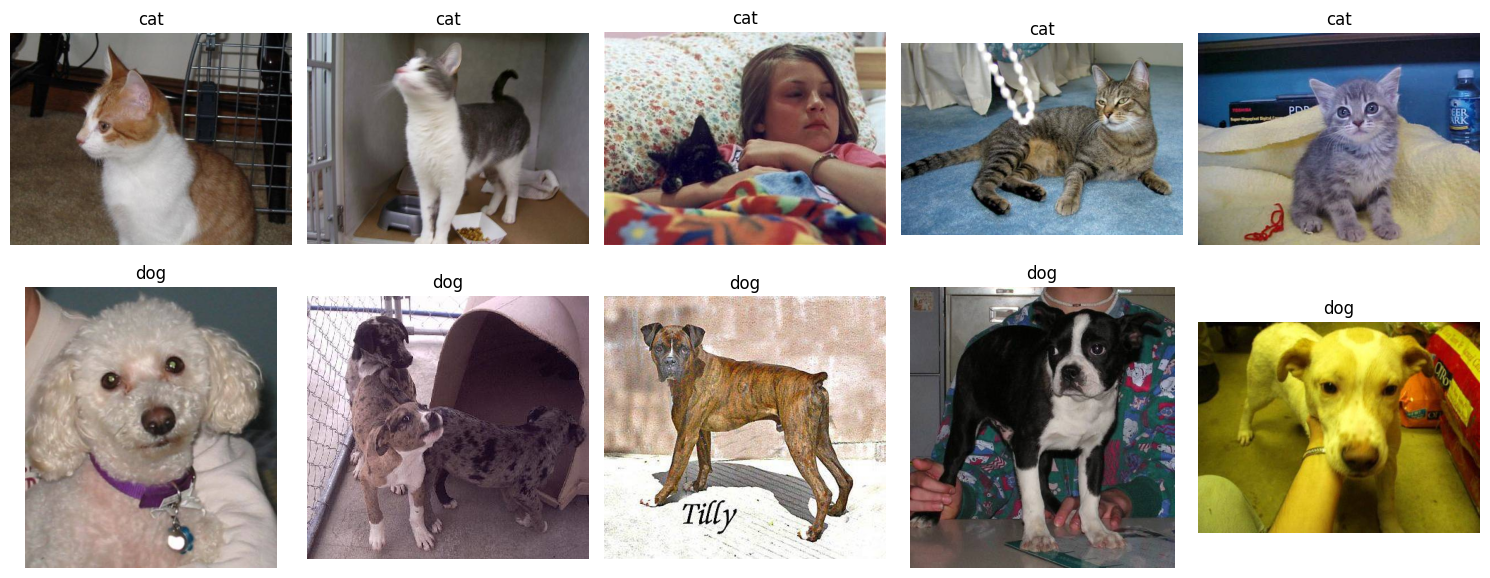

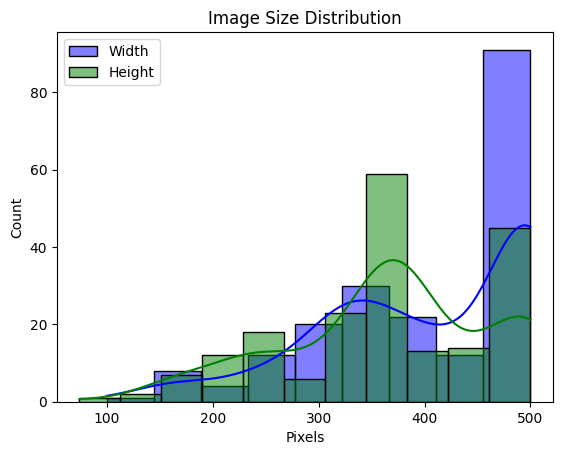

Corrupted Images:
 []


In [51]:
#here we are setting the main dataset that will be selected from the small dataset to work on
base_dir = pathlib.Path("../data/kaggle_dogs_vs_cats_small")

#these are the folder that i want it to be in the new folder
categories = ['cat', 'dog']
subsets = ['train', 'validation', 'test']

#here the main file structure contains of 3 subsets train, validation and test
#in each folder of the subset .. i need to have 2 categories "cat" and "dog"
#and the overall result is to get results
def count_images():
    counts = {}
    for subset in subsets:
        for category in categories:
            dir_path = base_dir / subset / category
            count = len(os.listdir(dir_path))
            counts[f"{subset}_{category}"] = count
    return counts

#here we are making 2 plot rows
#the first row is for cats and the second one is for dogs
def show_sample_images():
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i, category in enumerate(categories):
        dir_path = base_dir / "train" / category
        files = list(os.listdir(dir_path))[:5]
        for j, file in enumerate(files):
            img = Image.open(dir_path / file)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f"{category}")
    plt.tight_layout()
    plt.show()

#here im analysing the images in each category in train folder for the first 100 images
def analyze_image_sizes():
    widths, heights = [], []
    for category in categories:
        dir_path = base_dir / "train" / category
        files = list(os.listdir(dir_path))[:100]
        for file in files:
            try:
                img = Image.open(dir_path / file)
                widths.append(img.size[0])
                heights.append(img.size[1])
            except Exception as e:
                print(f"Error reading image {file}: {e}")
    sns.histplot(widths, kde=True, color='blue', label='Width')
    sns.histplot(heights, kde=True, color='green', label='Height')
    plt.legend()
    plt.title("Image Size Distribution")
    plt.xlabel("Pixels")
    plt.show()

#check for corrupted images in each subset in each category ,, if it cannot be opened so it will append the path in the array
def check_corrupted_images():
    corrupted = []
    for subset in subsets:
        for category in categories:
            dir_path = base_dir / subset / category
            for file in os.listdir(dir_path):
                try:
                    img = Image.open(dir_path / file)
                    img.verify()
                except Exception:
                    corrupted.append(str(dir_path / file))
    return corrupted

# Run EDA
print("Image Counts:\n", count_images())
show_sample_images()
analyze_image_sizes()
print("Corrupted Images:\n", check_corrupted_images())


This chart shows that most images have widths around 500 pixels, while heights vary more. The data looks clean, with no corrupted images listed.

and there are no corrupted images.

<h3><p style="color:red">Train two networks (use callbacks to save the best model version):<br>
Define a Neural Network of your choice (3 points)<br>
Fine-Tune VGG16 (pre-trained on imagenet). Make sure to use validation to test for over-fitting. Plot the appropriate graph (3 points)</p></h3>

## Build and Train a Custom CNN

We define and train a simple Convolutional Neural Network (CNN) from scratch.

Key steps:

- Normalize images using `ImageDataGenerator`.
- Use callbacks to save the best-performing model and prevent overfitting.
- Train for 20 epochs and validate using a validation set.

In [52]:
#setting up the size and the batch
img_size = (150, 150)
batch_size = 32

#this is our selected dataset
base_dir = "../data/kaggle_dogs_vs_cats_small"

#the preprocessor gives us the range between 0 and 1 not the 255 format for easy learning somethign or in other words normalization before training
#https://stackoverflow.com/questions/50065555/how-does-keras-imagedatagenerator-rescale-parameter-works
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

#Load  the images images resized with the size 150X150 defined before with the batch size of 32
#labeling the images with 0 cat and 1 to be dog
#these images will be used to be trained on
train_gen = train_datagen.flow_from_directory(
    base_dir + "/train", target_size=img_size, batch_size=batch_size, class_mode='binary')
val_gen = val_test_datagen.flow_from_directory(
    base_dir + "/validation", target_size=img_size, batch_size=batch_size, class_mode='binary')

#callbacks
#saves the model to "custom_cnn_best.h5" only when validation accuracy improves
#stops training if validation accuracy doesn’t improve for 5 epochs in a row
custom_cnn_cb = [
    ModelCheckpoint("custom_cnn_best.h5", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Define simple CNN
#conv2d
    #1st parameter is the count of the filters
    #2nd parameter is the size of each filter
    #3rd parameter (relu) is to make less linearity to learn the complex patterns
#maxpooling
    #Keeps important features and reduces Overfitting.
custom_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),                                                  
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

#optimizer='adam': adaptive optimizer that adjusts learning rate
#binary_crossentropy: good for binary classification
#metrics=['accuracy']: evaluates how many predictions were correct.
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#train the model
history_custom = custom_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=custom_cnn_cb)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/dlpy311/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/dlpy311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5197 - loss: 1.6571

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.5197 - loss: 1.6615 - val_accuracy: 0.4980 - val_loss: 2.8287
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.5136 - loss: 1.5933 - val_accuracy: 0.4780 - val_loss: 0.8016
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5508 - loss: 0.8147

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.5505 - loss: 0.8147 - val_accuracy: 0.5300 - val_loss: 0.7096
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5469 - loss: 0.7350

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.5469 - loss: 0.7350 - val_accuracy: 0.5540 - val_loss: 0.6979
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5582 - loss: 0.7212

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5583 - loss: 0.7211 - val_accuracy: 0.5600 - val_loss: 0.6734
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6007 - loss: 0.6475 - val_accuracy: 0.5130 - val_loss: 0.8437
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.5545 - loss: 0.7290 - val_accuracy: 0.5490 - val_loss: 0.7450
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6339 - loss: 0.6344

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6343 - loss: 0.6340 - val_accuracy: 0.6780 - val_loss: 0.5992
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.6579 - loss: 0.6081 - val_accuracy: 0.6780 - val_loss: 0.6044
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7303 - loss: 0.5164 - val_accuracy: 0.6780 - val_loss: 0.6223
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7143 - loss: 0.5684

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.7143 - loss: 0.5687 - val_accuracy: 0.6850 - val_loss: 0.5903
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7585 - loss: 0.5015

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7585 - loss: 0.5014 - val_accuracy: 0.6860 - val_loss: 0.7254
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6699 - loss: 0.7975

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.6704 - loss: 0.7962 - val_accuracy: 0.7080 - val_loss: 0.6222
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.7992 - loss: 0.4288 - val_accuracy: 0.6430 - val_loss: 0.7154
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.7852 - loss: 0.4462 - val_accuracy: 0.7000 - val_loss: 0.6545
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.8178 - loss: 0.4051 - val_accuracy: 0.7010 - val_loss: 0.6546


<h3><p style="color:red">Explore the relative performance of the models (make sure to load the best version of each model) (6 points):<br>
accuracy<br>
confusion metric<br>
precision, recall, F1-score,<br>
precision-recall curve.<br>
Explore specific examples in which the model failed to predict correctly.</p></h3>

## Fine-Tune VGG16 (Transfer Learning)

We now leverage the power of transfer learning by using a pre-trained VGG16 model.

- Load VGG16 without its top classifier layers.
- Freeze all convolutional layers.
- Add a custom dense head for binary classification.
- Train only the new head layers while keeping VGG16’s weights frozen.

In [53]:
#loads the VGG16 model pre-trained on ImageNet (a large dataset of over 14 million images).
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

#this prevents overfitting and speeds up training and prevents the overfitting.
base_vgg.trainable = False

x = layers.Flatten()(base_vgg.output)
x = layers.Dense(256, activation='relu')(x)


#Randomly turns off 50% of the neurons in this layer during training.
#Prevents overfitting by forcing the network to not rely too much on any single neuron.
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

vgg_model = Model(base_vgg.input, output)

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#metrics=['accuracy']: We want to track how many predictions are correct.
vgg_cb = [
    ModelCheckpoint("vgg16_finetuned_best.h5", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(patience=5, restore_best_weights=True)
]

#train
history_vgg = vgg_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=vgg_cb)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5897 - loss: 2.9702

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.5904 - loss: 2.9633 - val_accuracy: 0.8500 - val_loss: 0.4674
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7070 - loss: 1.8775

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.7071 - loss: 1.8751 - val_accuracy: 0.8720 - val_loss: 0.4156
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7770 - loss: 1.2225

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.7770 - loss: 1.2231 - val_accuracy: 0.8850 - val_loss: 0.4759
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7976 - loss: 1.1195

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.7978 - loss: 1.1185 - val_accuracy: 0.9040 - val_loss: 0.4009
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.8207 - loss: 0.8922 - val_accuracy: 0.9000 - val_loss: 0.4541
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8630 - loss: 0.6564

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.8631 - loss: 0.6558 - val_accuracy: 0.9060 - val_loss: 0.4015
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 290ms/step - accuracy: 0.8958 - loss: 0.4426 - val_accuracy: 0.8950 - val_loss: 0.4435
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.9136 - loss: 0.4041 - val_accuracy: 0.8930 - val_loss: 0.5011
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.9081 - loss: 0.3579 - val_accuracy: 0.8930 - val_loss: 0.5051


## Plot Training Accuracy and Loss

Visualize training and validation performance for both models:

- Accuracy over epochs
- Loss over epochs

These plots help us understand the learning behavior and detect overfitting or underfitting.

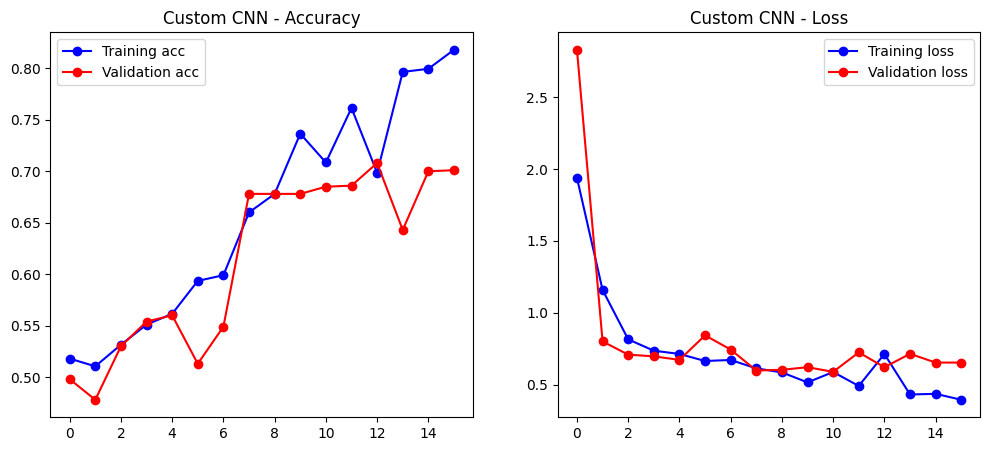

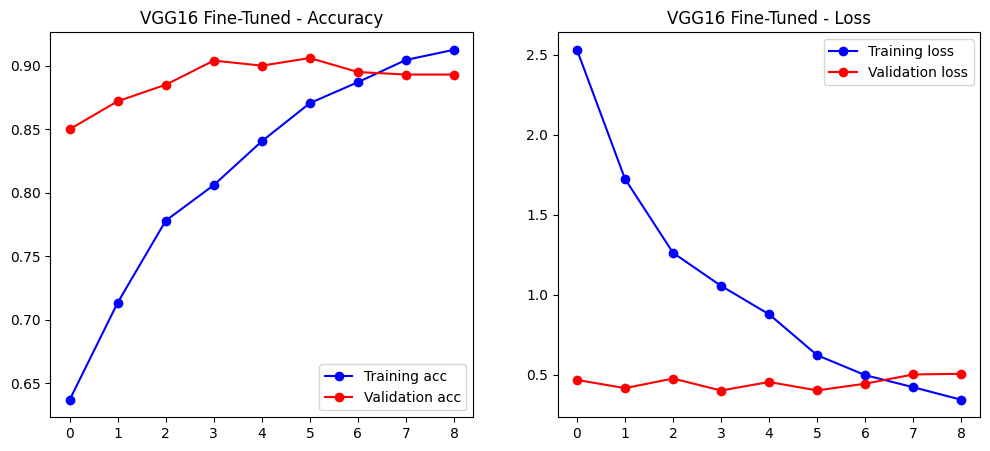

In [54]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

plot_history(history_custom, "Custom CNN")
plot_history(history_vgg, "VGG16 Fine-Tuned")


The top-left (Custom CNN Accuracy) plot shows a steady increase in training accuracy, but validation accuracy peaks around epoch 6 and then slightly declines, indicating the model starts to overfit.

The top-right (Custom CNN Loss) plot shows decreasing training loss, but validation loss rises after a few epochs and spikes at the end, clearly confirming overfitting.

The bottom-left (VGG16 Accuracy) plot demonstrates both training and validation accuracy rising and staying close, showing strong generalization and minimal overfitting.

The bottom-right (VGG16 Loss) plot confirms stable training, with both losses decreasing together and staying close, indicating the model is learning well and generalizing properly.

## Prepare the Test Dataset

We now create a test data generator using `ImageDataGenerator`. This set will be used for evaluating the models on unseen data.

In [55]:
img_size = (150, 150)
batch_size = 32
test_dir = "../data/kaggle_dogs_vs_cats_small/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 2000 images belonging to 2 classes.


## Evaluation Function

We create a reusable function to:

- Predict on the test set
- Calculate accuracy
- Display a confusion matrix
- Print classification report (precision, recall, F1-score)
- Plot the precision-recall curve
- Show a few misclassified images

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

Evaluating: Custom CNN
Prediction shape: (2000,)
Any NaNs? False
Custom CNN Accuracy: 0.7000


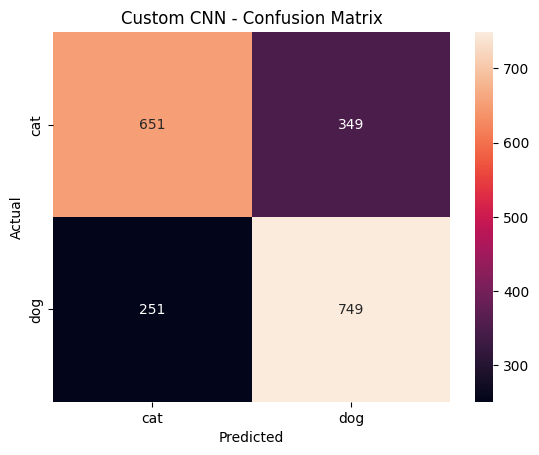


Custom CNN Classification Report:
              precision    recall  f1-score   support

         cat       0.72      0.65      0.68      1000
         dog       0.68      0.75      0.71      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



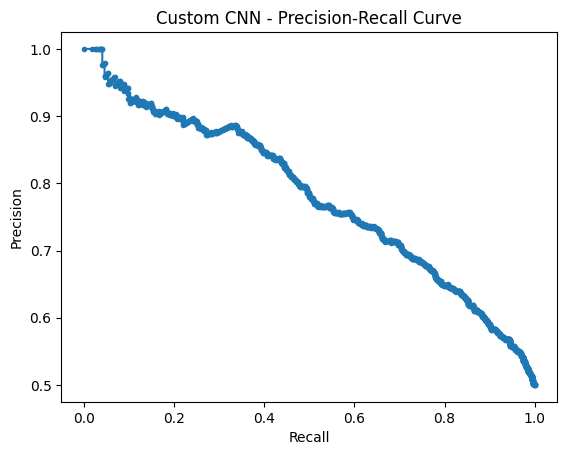


Custom CNN - Misclassified examples: 600


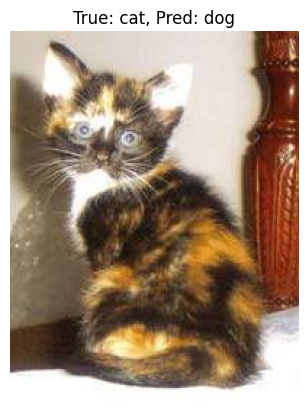

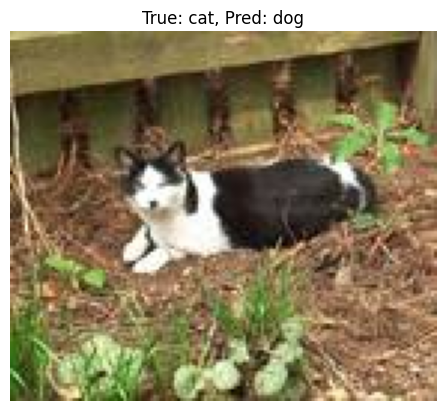

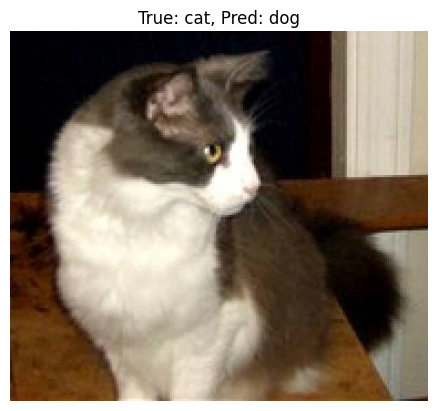

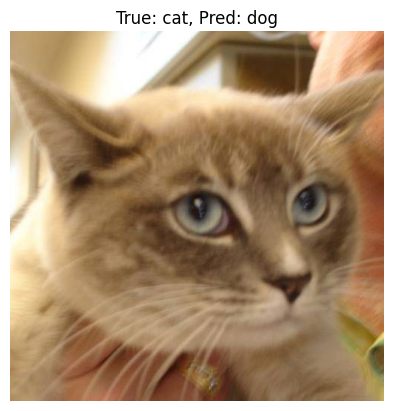

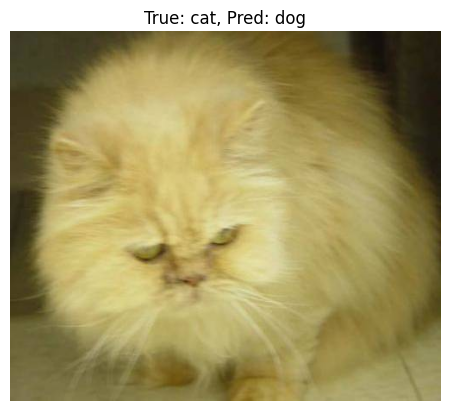

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step

Evaluating: Fine-Tuned VGG16
Prediction shape: (2000,)
Any NaNs? False
Fine-Tuned VGG16 Accuracy: 0.8835


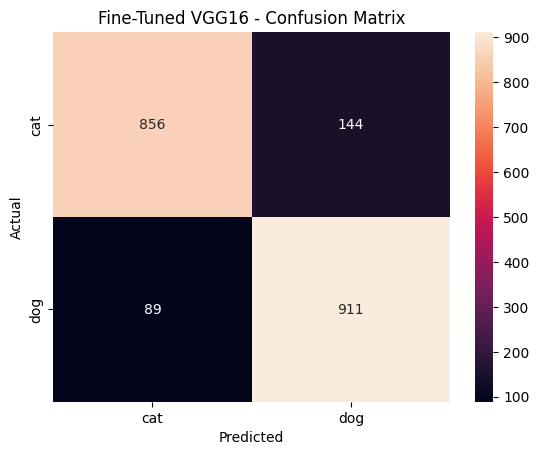


Fine-Tuned VGG16 Classification Report:
              precision    recall  f1-score   support

         cat       0.91      0.86      0.88      1000
         dog       0.86      0.91      0.89      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



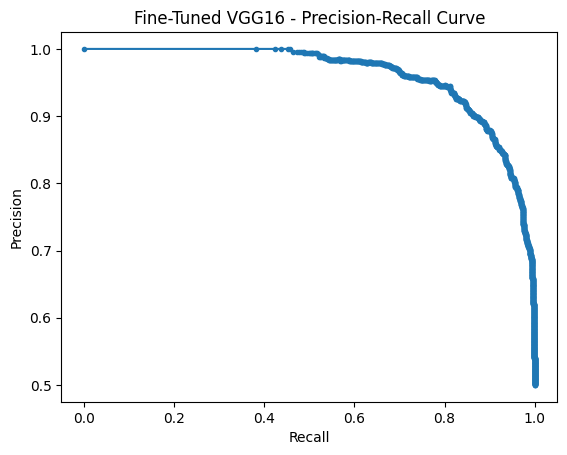


Fine-Tuned VGG16 - Misclassified examples: 233


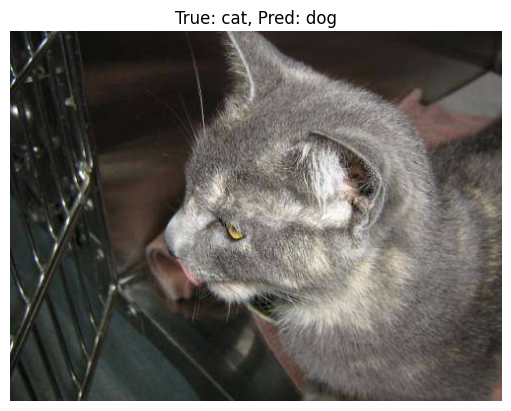

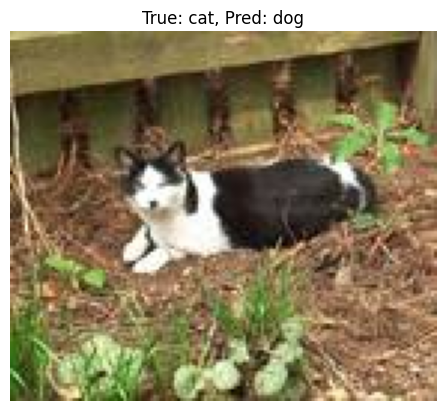

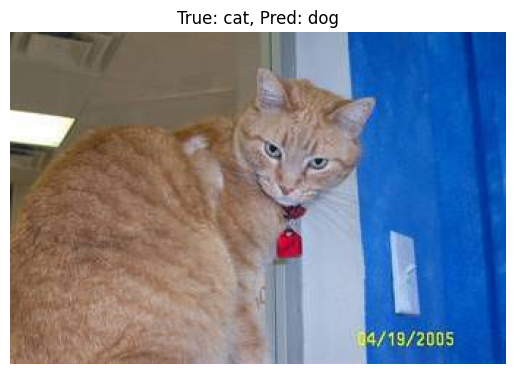

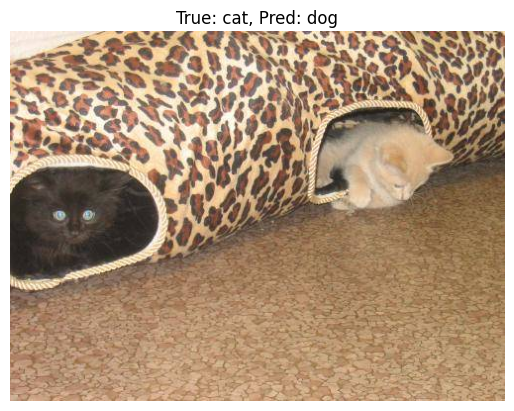

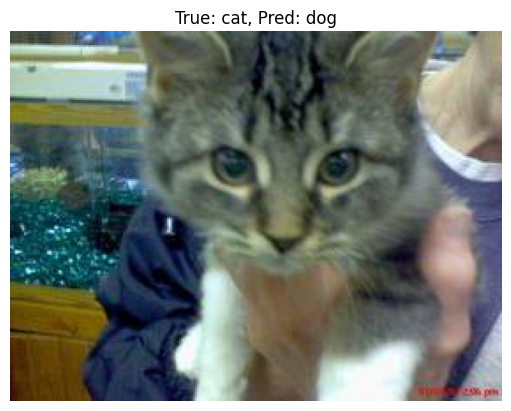

In [56]:
def evaluate_model(model, model_name):
    predictions = model.predict(test_gen, verbose=1).flatten()
    true_classes = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    print(f"\nEvaluating: {model_name}")
    print(f"Prediction shape: {predictions.shape}")
    print(f"Any NaNs? {np.isnan(predictions).any()}")

    if np.isnan(predictions).any():
        print("NaNs detected in predictions. Skipping evaluation.")
        return

    predicted_classes = (predictions > 0.5).astype(int)

    acc = np.mean(predicted_classes == true_classes)
    print(f"{model_name} Accuracy: {acc:.4f}")

    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"\n{model_name} Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    precision, recall, _ = precision_recall_curve(true_classes, predictions)
    plt.plot(recall, precision, marker='.')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    misclassified = np.where(predicted_classes != true_classes)[0]
    print(f"\n{model_name} - Misclassified examples: {len(misclassified)}")

    for i in misclassified[:5]:
        img_path = test_gen.filepaths[i]
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"True: {class_labels[true_classes[i]]}, Pred: {class_labels[predicted_classes[i]]}")
        plt.axis('off')
        plt.show()

custom_model = load_model("custom_cnn_best.h5")
vgg_model = load_model("vgg16_finetuned_best.h5")

evaluate_model(custom_model, "Custom CNN")
evaluate_model(vgg_model, "Fine-Tuned VGG16")


In [57]:
print("Total test images:", len(test_gen.filenames))

Total test images: 2000


<h3><p style="color:red">Add your conclusions. (3 point)</p></h3>

### Conclusion

The Custom CNN achieved an overall accuracy of 70%, showing it can distinguish between cats and dogs to a fair extent. However, the confusion matrix reveals a significant number of misclassifications, especially in predicting cats. The precision-recall curve confirms inconsistent confidence, with precision dropping as recall increases. This suggests the model struggles to maintain balance between identifying all positives and minimizing false positives, likely due to overfitting and limited model depth.

The Fine-Tuned VGG16 significantly outperforms the custom model with an accuracy of 88%. It shows strong performance in both precision and recall for both classes, as seen in the classification report and confusion matrix. The precision-recall curve remains high and stable, indicating that the model makes confident and accurate predictions across various thresholds. Transfer learning from ImageNet clearly helps the model generalize better and make fewer mistakes, with only 233 misclassified samples out of 2000.